<a href="https://colab.research.google.com/github/Manas8114/DBMS-skyline/blob/main/week_1%2C2%2C3%2C4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import chardet
import csv
import logging
from io import StringIO

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# File path to the CSV
file_path = '/content/apartments_for_rent_classified_100K.csv'

# Function to detect encoding using chardet
def detect_encoding_chardet(file_path):
    with open(file_path, 'rb') as file:
        result = chardet.detect(file.read(100000))
    logging.info(f"Chardet detected encoding: {result['encoding']}")
    return result['encoding']

# Function to read and preprocess CSV file with custom error handling
def read_csv_with_custom_handling(file_path, encoding='utf-8', delimiter=';'):
    try:
        # Read the file using Python's built-in CSV reader for flexible handling
        with open(file_path, 'r', encoding=encoding, errors='replace') as file:
            reader = csv.reader(file, delimiter=delimiter, quoting=csv.QUOTE_NONE)
            rows = list(reader)

        # Convert the CSV rows to a pandas DataFrame
        df = pd.DataFrame(rows[1:], columns=rows[0])
        logging.info(f"Successfully read file with custom handling using encoding: {encoding}")
        return df

    except Exception as e:
        logging.error(f"Error reading CSV with custom handling: {e}")
        return None

# Function to clean numeric columns with currency symbols and commas
def clean_currency(x):
    if isinstance(x, str):
        x = x.replace('$', '').replace(',', '').strip()
        # Check for null or non-numeric values
        if x.lower() in ['null', '', 'none']:
            return 0.0
        try:
            return float(x)
        except ValueError:
            return 0.0
    return x

# Pre-processing the dataset
def preprocess_dataset(df):
    # Clean the price and fee columns
    df['price'] = df['price'].apply(clean_currency)
    df['price_display'] = df['price_display'].apply(clean_currency)
    df['fee'] = df['fee'].apply(lambda x: 0 if x == 'No' else clean_currency(x))

    # Handle missing data in amenities
    df['amenities'] = df['amenities'].fillna('None')

    # Handle boolean conversion
    df['has_photo'] = df['has_photo'].apply(lambda x: True if x == 'Thumbnail' else False)
    df['pets_allowed'] = df['pets_allowed'].apply(lambda x: True if x in ['Cats', 'Dogs', 'Cats Dogs'] else False)

    # Convert bathrooms and bedrooms to numeric
    df['bathrooms'] = pd.to_numeric(df['bathrooms'], errors='coerce')
    df['bedrooms'] = pd.to_numeric(df['bedrooms'], errors='coerce')

    # Handle missing and incorrect data in 'square_feet'
    df['square_feet'] = pd.to_numeric(df['square_feet'], errors='coerce').fillna(0)

    # Convert 'time' to a datetime format
    df['time'] = pd.to_datetime(df['time'], unit='s')

    # Handle 'price_type' column
    df['price_type'] = df['price_type'].replace({'Monthly': 'Per Month'})

    return df

# Main function to execute the script
def main():
    # Step 1: Detect encoding using chardet
    encoding = detect_encoding_chardet(file_path)

    # Step 2: Try reading the file with custom handling
    df = read_csv_with_custom_handling(file_path, encoding=encoding)

    if df is None:
        logging.error("Failed to read the CSV file using all methods.")
        return

    # Step 3: Preprocess the DataFrame
    df_processed = preprocess_dataset(df)

    # Display the processed data
    logging.info("Processed Data:")
    print(df_processed.head())

    # Save the processed DataFrame to a new CSV file (optional)
    output_file_path = '/content/processed_apartments_for_rent.csv'
    df_processed.to_csv(output_file_path, index=False)
    logging.info(f"Processed data saved to {output_file_path}")

# Run the main function
if __name__ == "__main__":
    main()


<ipython-input-16-3b320db47250>:72: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['time'] = pd.to_datetime(df['time'], unit='s')


           id                category                            title  \
0  5668640009  housing/rent/apartment       One BR 507 & 509 Esplanade   
1  5668639818  housing/rent/apartment      Three BR 146 Lochview Drive   
2  5668639686  housing/rent/apartment  Three BR 3101 Morningside Drive   
3  5668639659  housing/rent/apartment            Two BR 209 Aegean Way   
4  5668639374  housing/rent/apartment         One BR 4805 Marquette NE   

                                                body amenities  bathrooms  \
0  This unit is located at 507 & 509 Esplanade, R...      null        1.0   
1  This unit is located at 146 Lochview Drive, Ne...      null        1.5   
2  This unit is located at 3101 Morningside Drive...      null        2.0   
3  This unit is located at 209 Aegean Way, Vacavi...      null        1.0   
4  This unit is located at 4805 Marquette NE, Alb...      null        1.0   

   bedrooms currency  fee  has_photo  ...  price_display  price_type  \
0       1.0      USD

In [1]:
pip install pandas scikit-learn

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt

<ipython-input-14-92e37433ecc9>:2: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/processed_apartments_for_rent.csv')


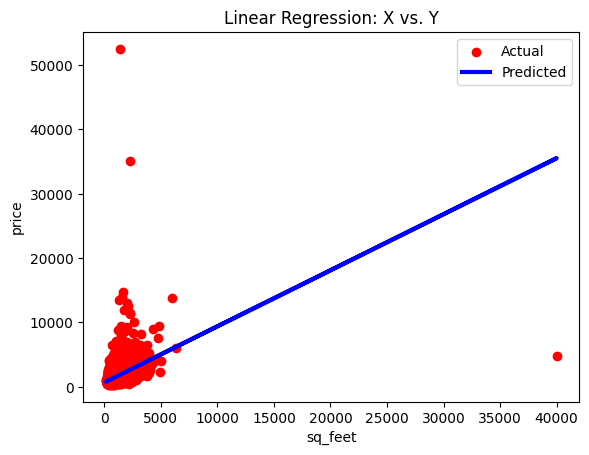

Coefficient: 0.8705488969238842
Intercept: 695.85267170667
R^2 score: 0.06339830090331822
mean sq error: 768053.377755756


In [14]:


# Load the dataset
df = pd.read_csv('/content/processed_apartments_for_rent.csv')

# Define features and target
X = df[['square_feet']]
Y = df['price']

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, Y_train)
# Make predictions
Y_pred = model.predict(X_test)
mse=mean_squared_error(Y_test, Y_pred)


# Plot the results
plt.scatter(X_test, Y_test, color='red', label='Actual')
plt.plot(X_test, Y_pred, color='blue', linewidth=3, label='Predicted')
plt.xlabel('sq_feet')
plt.ylabel('price')
plt.title('Linear Regression: X vs. Y')
plt.legend()
plt.show()

# Print the coefficients
print('Coefficient:', model.coef_[0])
print('Intercept:', model.intercept_)
print('R^2 score:', model.score(X_test, Y_test))
print('mean sq error:', mse)


ValueError: Expected 2D array, got 1D array instead:
array=[1934.  735. 2395. ... 2765. 1500. 1222.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

<ipython-input-24-d580442176a6>:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/processed_apartments_for_rent.csv')


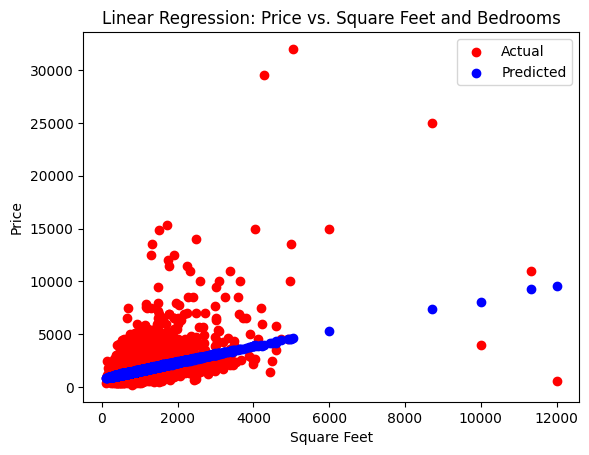

Coefficients: [ 0.73268983 35.24094735]
Intercept: 764.9454522452612
R^2 score: 0.16902975166545264
Mean Squared Error: 647313.5766242647


In [24]:
df = pd.read_csv('/content/processed_apartments_for_rent.csv')

# Drop rows with missing values for 'price', 'square_feet', and 'bedrooms'
df_clean = df.dropna(subset=['price', 'square_feet', 'bedrooms'])

# Split the dataset into features and target variable
X_clean = df_clean[['square_feet', 'bedrooms']]
Y_clean = df_clean['price']

# Split the cleaned data into training and testing sets
X_train_clean, X_test_clean, Y_train_clean, Y_test_clean = train_test_split(X_clean, Y_clean, test_size=0.2, random_state=0)

# Initialize the Linear Regression model
model_clean = LinearRegression()

# Fit the model on the training data
model_clean.fit(X_train_clean, Y_train_clean)

# Predict the target variable on the testing data
Y_pred_clean = model_clean.predict(X_test_clean)

# Calculate the Mean Squared Error and R^2 score
mse_clean = mean_squared_error(Y_test_clean, Y_pred_clean)
r2_clean = r2_score(Y_test_clean, Y_pred_clean)

# Plot the results
plt.scatter(X_test_clean['square_feet'], Y_test_clean, color='red', label='Actual')
plt.scatter(X_test_clean['square_feet'], Y_pred_clean, color='blue', label='Predicted')
plt.xlabel('Square Feet')
plt.ylabel('Price')
plt.title('Linear Regression: Price vs. Square Feet and Bedrooms')
plt.legend()
plt.show()

# Print the coefficients, intercept, R^2 score, and mean squared error
print('Coefficients:', model_clean.coef_)
print('Intercept:', model_clean.intercept_)
print('R^2 score:', r2_clean)
print('Mean Squared Error:', mse_clean)

<ipython-input-25-eba0ee679294>:9: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/processed_apartments_for_rent.csv')


Accuracy: 0.66
Confusion Matrix:
[[10687  1357]
 [ 5506  2426]]
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.89      0.76     12044
           1       0.64      0.31      0.41      7932

    accuracy                           0.66     19976
   macro avg       0.65      0.60      0.59     19976
weighted avg       0.65      0.66      0.62     19976



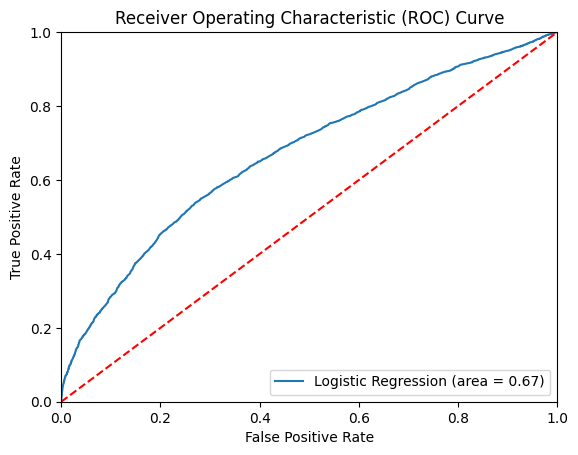

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc

# Load the dataset
df = pd.read_csv('/content/processed_apartments_for_rent.csv')

# Define a threshold for classifying the apartments
threshold = 1500  # Set a threshold for price to classify as 'Expensive' or 'Affordable'

# Create a new binary column 'price_class'
df['price_class'] = np.where(df['price'] > threshold, 1, 0)

# Drop rows with missing values for 'square_feet', 'bedrooms', and 'price_class'
df_clean = df.dropna(subset=['square_feet', 'bedrooms', 'price_class'])

# Define features and target variable
X_clean = df_clean[['square_feet', 'bedrooms']]
Y_clean = df_clean['price_class']

# Split the cleaned data into training and testing sets
X_train_clean, X_test_clean, Y_train_clean, Y_test_clean = train_test_split(X_clean, Y_clean, test_size=0.2, random_state=0)

# Initialize the Logistic Regression model
logistic_model = LogisticRegression()

# Fit the model on the training data
logistic_model.fit(X_train_clean, Y_train_clean)

# Predict the target variable on the testing data
Y_pred_clean = logistic_model.predict(X_test_clean)

# Calculate accuracy, confusion matrix, and classification report
accuracy = accuracy_score(Y_test_clean, Y_pred_clean)
conf_matrix = confusion_matrix(Y_test_clean, Y_pred_clean)
class_report = classification_report(Y_test_clean, Y_pred_clean)

# Print accuracy, confusion matrix, and classification report
print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# Plot ROC Curve
Y_pred_proba = logistic_model.predict_proba(X_test_clean)[::,1]
fpr, tpr, _ = roc_curve(Y_test_clean, Y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


<ipython-input-26-491cb9c92a4b>:9: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/processed_apartments_for_rent.csv')


Accuracy: 0.66
Confusion Matrix:
[[10686  1499]
 [ 5353  2462]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.88      0.76     12185
           1       0.62      0.32      0.42      7815

    accuracy                           0.66     20000
   macro avg       0.64      0.60      0.59     20000
weighted avg       0.65      0.66      0.62     20000



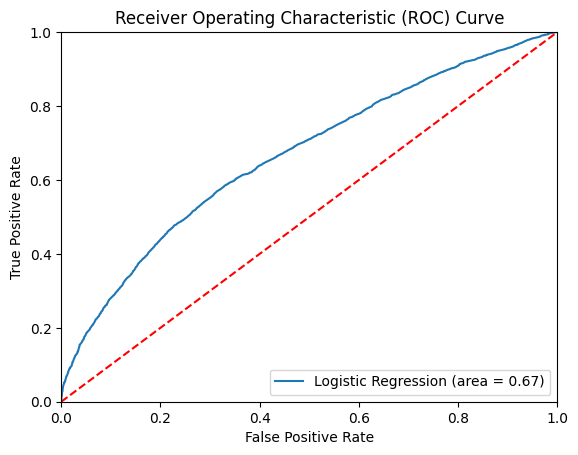

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc

# Load the dataset
df = pd.read_csv('/content/processed_apartments_for_rent.csv')

# Define a threshold for classifying the apartments
threshold = 1500  # Set a threshold for price to classify as 'Expensive' or 'Affordable'

# Create a new binary column 'price_class'
df['price_class'] = np.where(df['price'] > threshold, 1, 0)

# Drop rows with missing values for 'square_feet', 'bedrooms', and 'price_class'
df_clean = df.dropna(subset=['square_feet', 'price_class'])

# Define features and target variable
X_clean = df_clean[['square_feet', ]]
Y_clean = df_clean['price_class']

# Split the cleaned data into training and testing sets
X_train_clean, X_test_clean, Y_train_clean, Y_test_clean = train_test_split(X_clean, Y_clean, test_size=0.2, random_state=0)

# Initialize the Logistic Regression model
logistic_model = LogisticRegression()

# Fit the model on the training data
logistic_model.fit(X_train_clean, Y_train_clean)

# Predict the target variable on the testing data
Y_pred_clean = logistic_model.predict(X_test_clean)

# Calculate accuracy, confusion matrix, and classification report
accuracy = accuracy_score(Y_test_clean, Y_pred_clean)
conf_matrix = confusion_matrix(Y_test_clean, Y_pred_clean)
class_report = classification_report(Y_test_clean, Y_pred_clean)

# Print accuracy, confusion matrix, and classification report
print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# Plot ROC Curve
Y_pred_proba = logistic_model.predict_proba(X_test_clean)[::,1]
fpr, tpr, _ = roc_curve(Y_test_clean, Y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
